In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import random
import time
from tqdm import tqdm
import torchvision.utils as vutils
from timeit import default_timer as timer


In [ ]:
# Getting the MNIST Dataset

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform,
    target_transform=None
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform,
    target_transform=None
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3468531.98it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 450439.13it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4126087.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5196543.58it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Mini Batches
Batch_size=64
train_dataloader=DataLoader(train_data,batch_size=Batch_size, shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=Batch_size, shuffle = False)

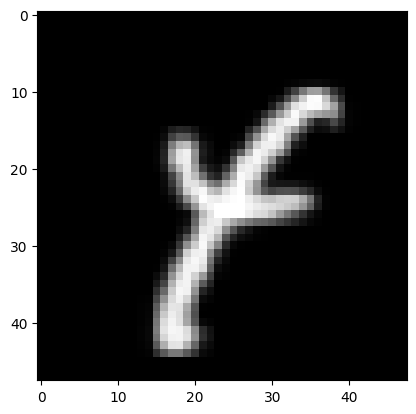

In [ ]:
# Checking the Data out
train_img_batch, train_label_batch = next(iter(train_dataloader))
img,label = train_img_batch[0],train_label_batch[0]
plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
# Architecture
class discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(discriminator, self).__init__()
    self.disc = nn.Sequential(
                                                                                  #image dimensions = N x channels_img x 48 x 48
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),  #o/p -> N x features_d x 24 x 24
        nn.LeakyReLU(0.2),
        self.block(features_d, features_d * 2, 4, 2, 1),                          #o/p -> N x features*2 x 12 x 12
        self.block(features_d * 2, features_d * 4, 4, 2, 1),                      #o/p -> N * features*4 x 6  x 6
        self.block(features_d * 4, features_d * 8, 4, 2, 1),                      #o/p -> N x features*8 x 3 x 3
        nn.Conv2d(features_d * 8, 1, kernel_size=3, stride=1, padding=0),         #o/p -> N x 1          x 1 x 1
        nn.Sigmoid()
      )
  def block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
        )
  def forward(self, x):
    return self.disc(x)

class generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(generator, self).__init__()
    self.gen = nn.Sequential(

                                                                                                # i/p -> N x z_dim x 1 x 1
        self.block(z_dim, features_g * 16, 3, 1, 0),                                            #o/p -> N x features_g*16 x 3 x 3
        self.block(features_g * 16, features_g * 8, 4, 2, 1),                                   #o/p -> N x features_g*8 x 6 x 6
        self.block(features_g * 8, features_g * 4, 4, 2, 1),                                    #o/p -> N x features_g*4 x 12 x 12
        self.block(features_g * 4, features_g * 2, 4, 2, 1),                                    #o/p -> N x features_g*2 x 24 x 24
        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),   #o/p -> N x channels_img x 48 x 48
        nn.Tanh(),
    )
  def block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, x):
        return self.gen(x)





In [ ]:
# Weight initialisation

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


Epoch [1/30]: 100%|██████████| 938/938 [01:03<00:00, 14.74batch/s, Loss D=0.7002, Loss G=0.8123]


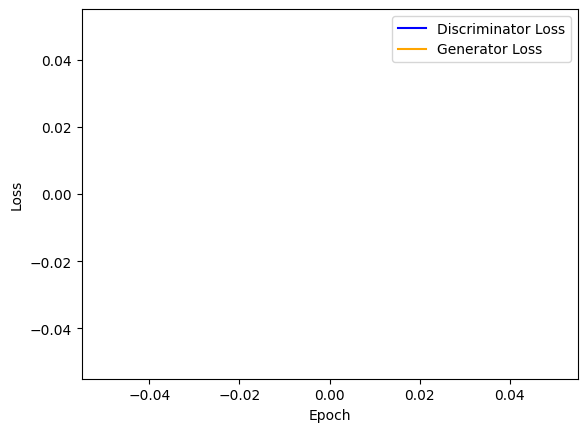

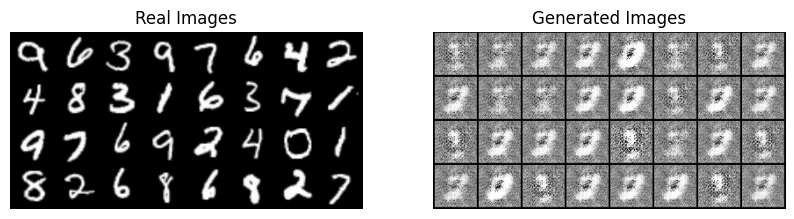

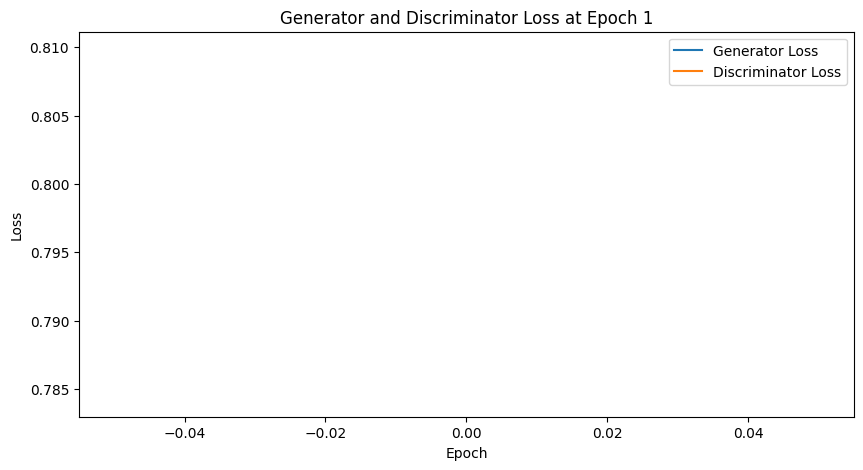

Epoch [2/30]: 100%|██████████| 938/938 [01:04<00:00, 14.53batch/s, Loss D=0.5405, Loss G=1.4309]


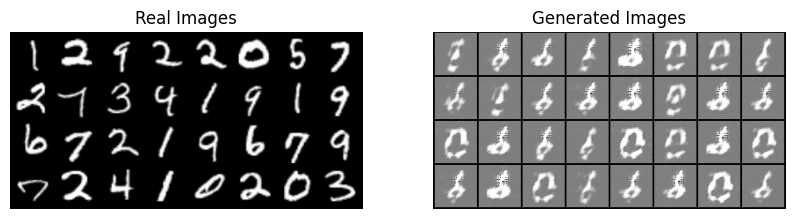

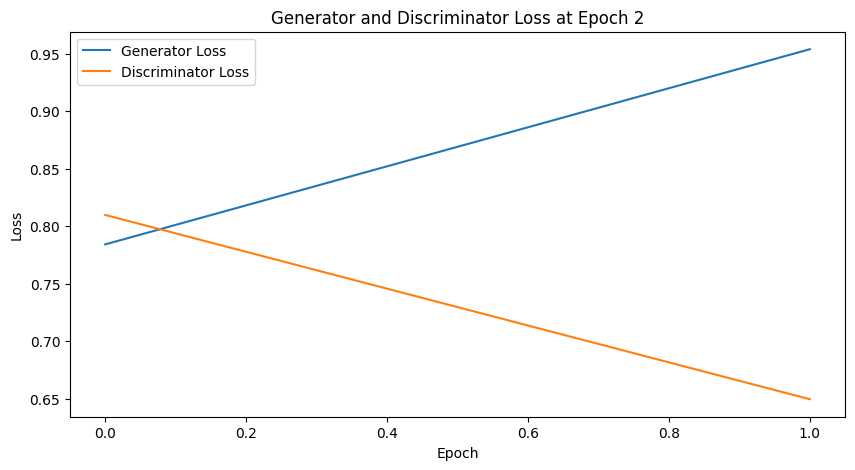

Epoch [3/30]: 100%|██████████| 938/938 [01:05<00:00, 14.35batch/s, Loss D=0.5917, Loss G=0.9511]


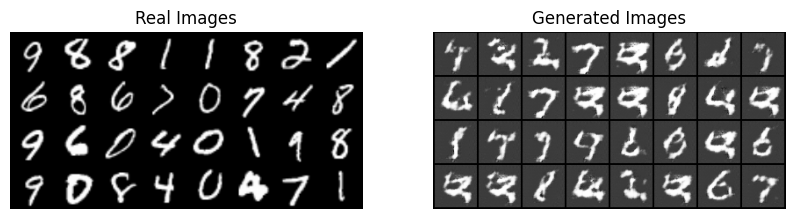

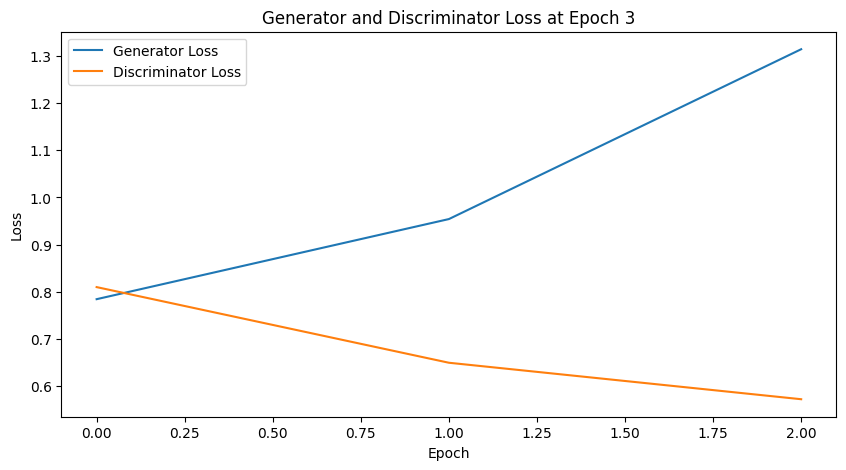

Epoch [4/30]: 100%|██████████| 938/938 [01:05<00:00, 14.30batch/s, Loss D=0.6168, Loss G=1.1869]


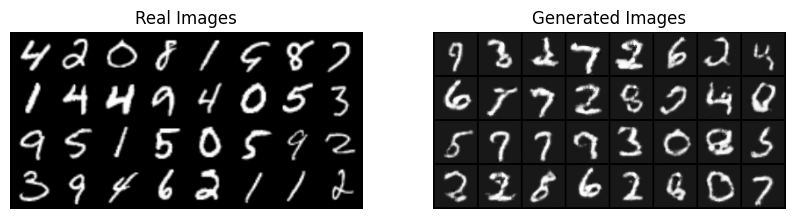

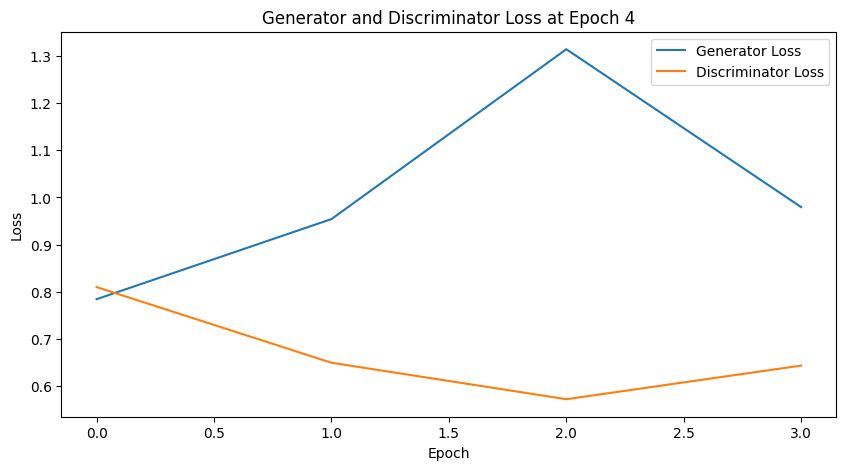

Epoch [5/30]: 100%|██████████| 938/938 [01:05<00:00, 14.26batch/s, Loss D=0.6833, Loss G=0.9389]


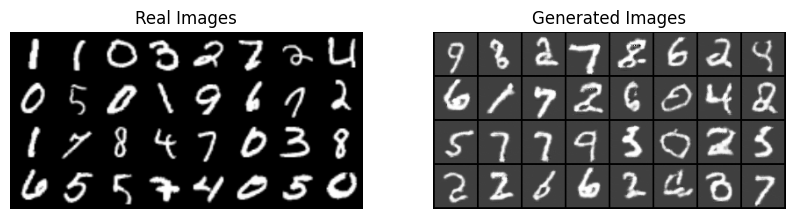

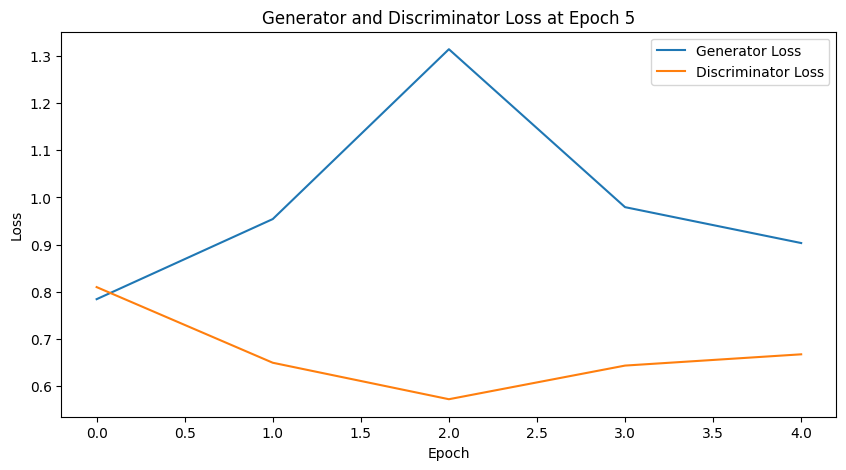

Epoch [6/30]: 100%|██████████| 938/938 [01:05<00:00, 14.28batch/s, Loss D=0.6731, Loss G=1.0549]


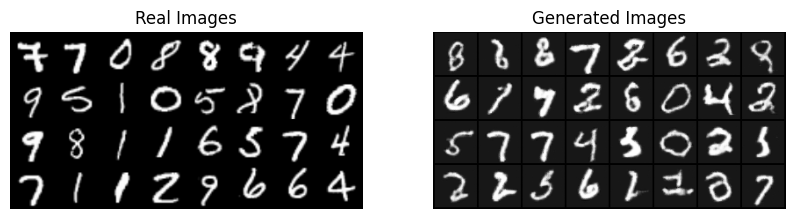

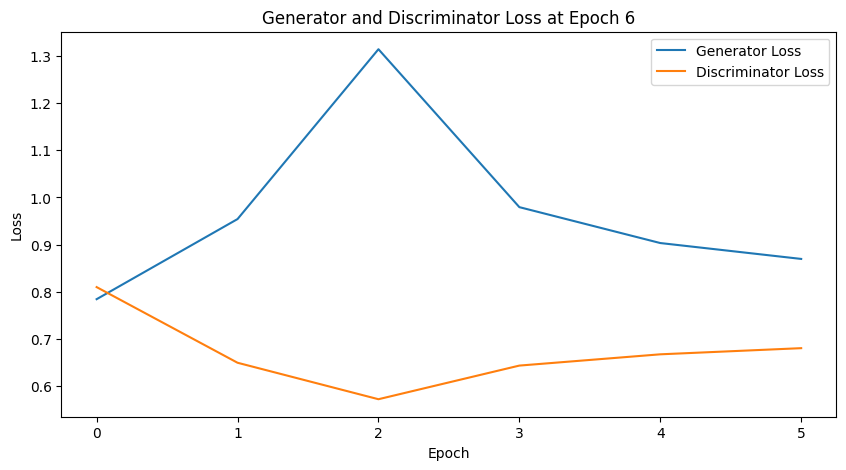

Epoch [7/30]: 100%|██████████| 938/938 [01:05<00:00, 14.23batch/s, Loss D=0.6731, Loss G=1.0050]


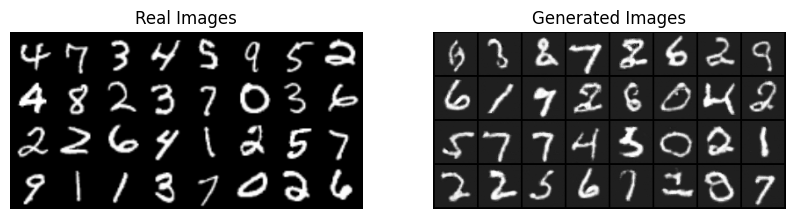

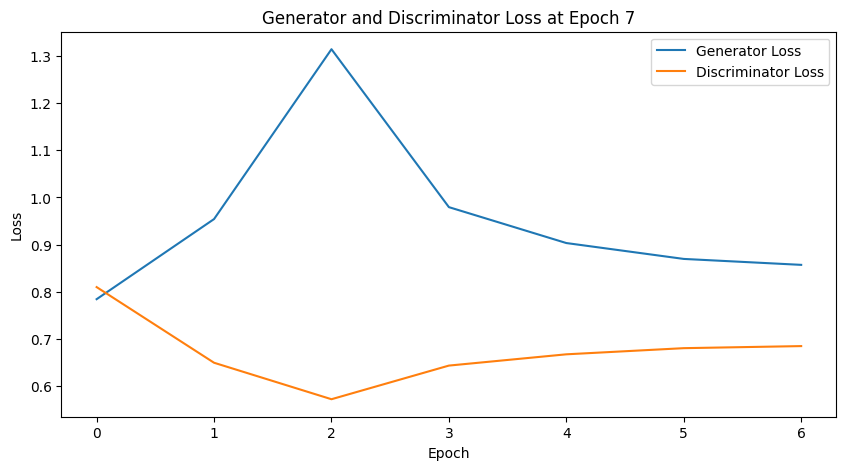

Epoch [8/30]: 100%|██████████| 938/938 [01:06<00:00, 14.18batch/s, Loss D=0.6662, Loss G=0.8900]


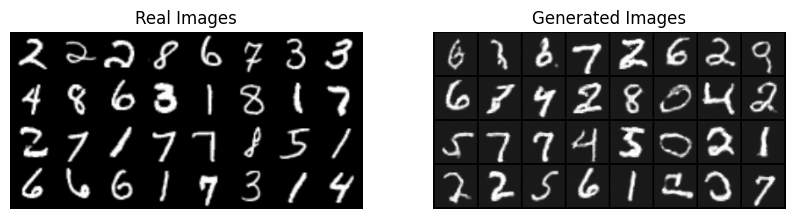

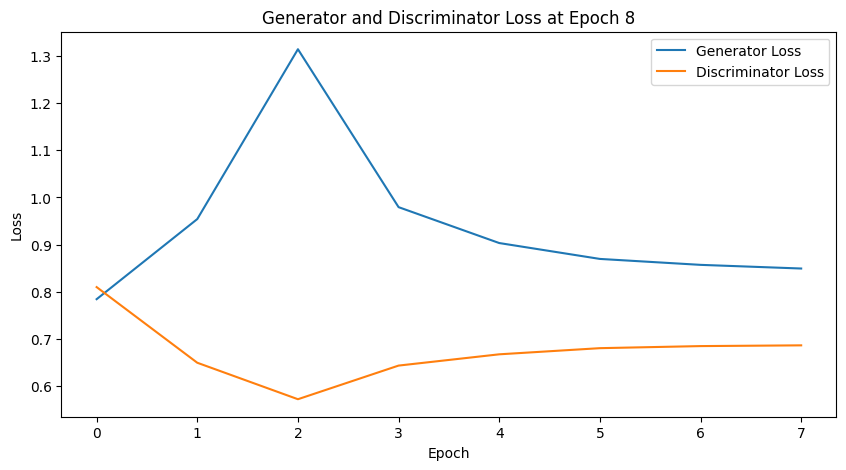

Epoch [9/30]: 100%|██████████| 938/938 [01:05<00:00, 14.22batch/s, Loss D=0.6844, Loss G=0.7921]


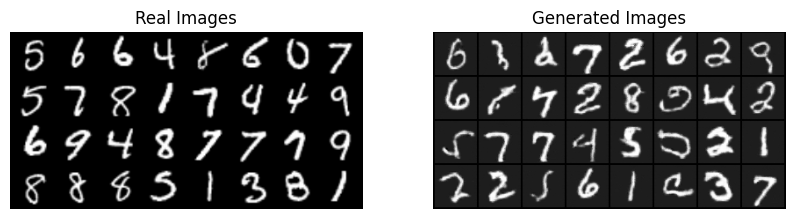

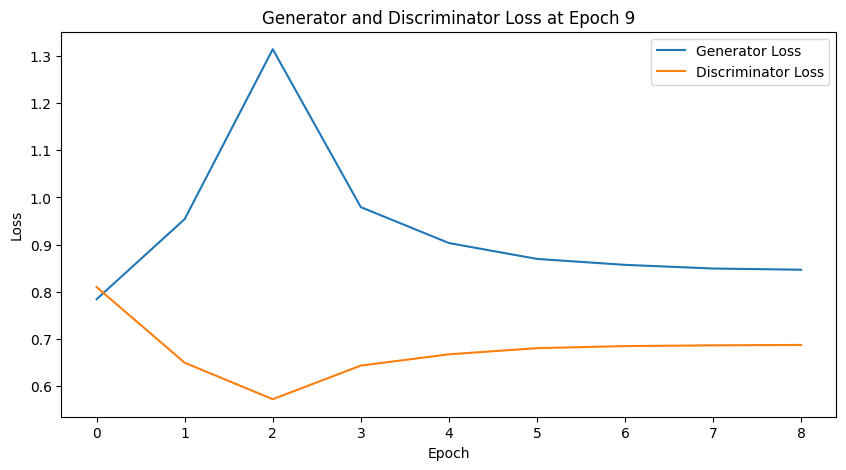

Epoch [10/30]: 100%|██████████| 938/938 [01:06<00:00, 14.21batch/s, Loss D=0.6992, Loss G=0.9378]


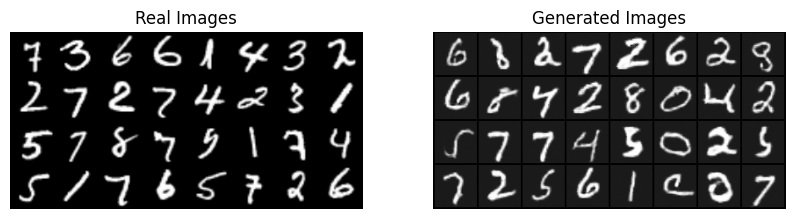

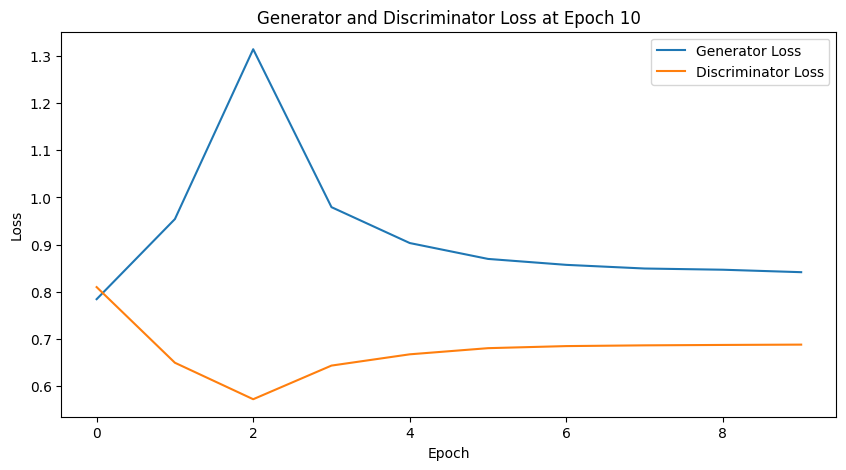

Epoch [11/30]: 100%|██████████| 938/938 [01:05<00:00, 14.24batch/s, Loss D=0.6911, Loss G=0.8516]


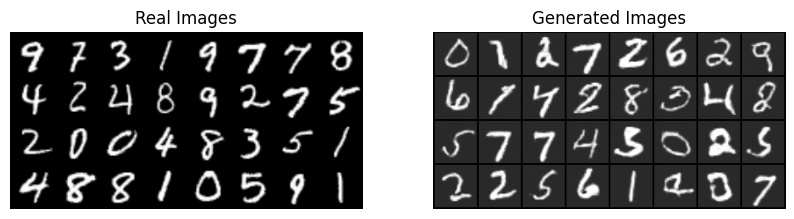

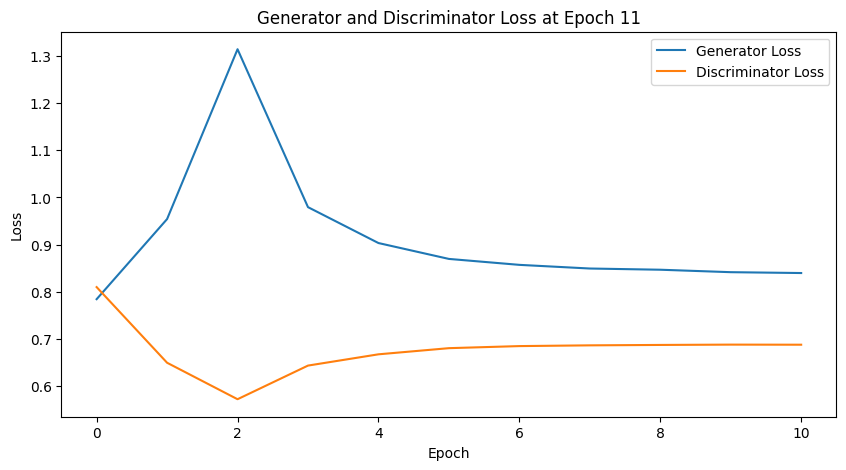

Epoch [12/30]: 100%|██████████| 938/938 [01:06<00:00, 14.16batch/s, Loss D=0.6881, Loss G=0.9040]


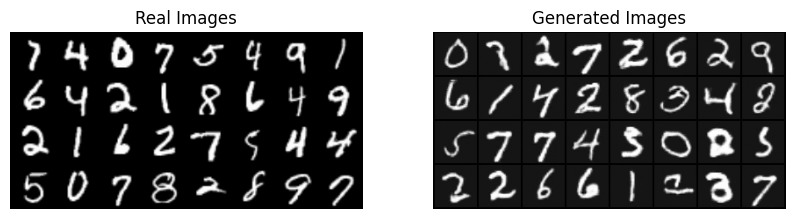

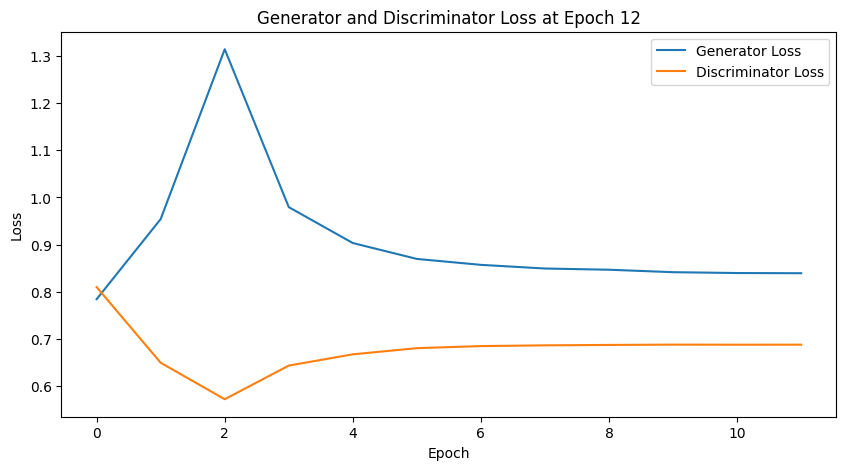

Epoch [13/30]: 100%|██████████| 938/938 [01:06<00:00, 14.20batch/s, Loss D=0.6861, Loss G=0.8326]


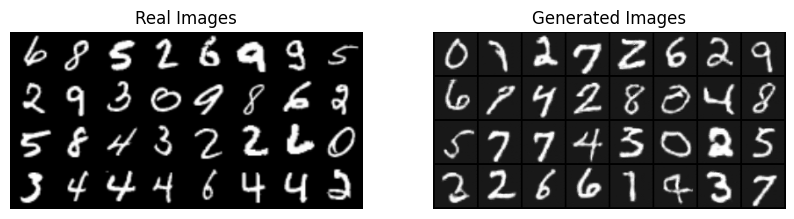

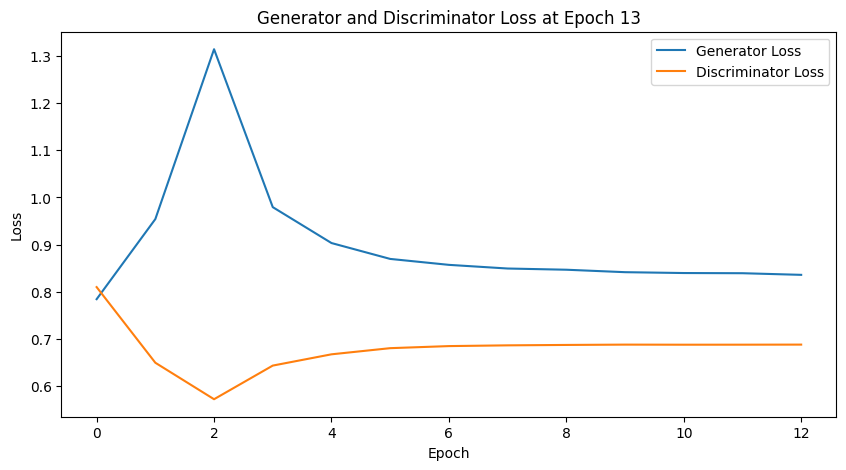

Epoch [14/30]: 100%|██████████| 938/938 [01:06<00:00, 14.13batch/s, Loss D=0.6689, Loss G=0.9097]


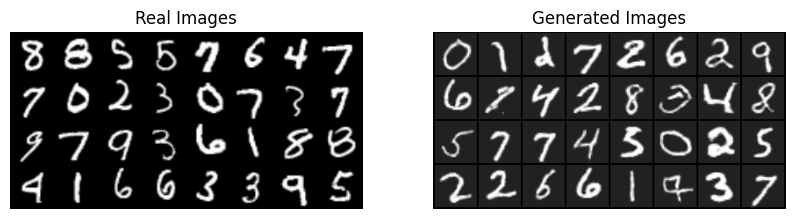

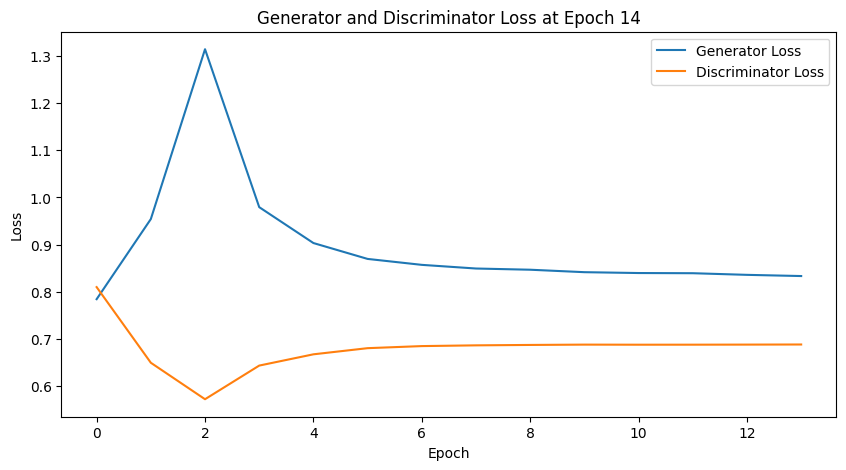

Epoch [15/30]: 100%|██████████| 938/938 [01:06<00:00, 14.19batch/s, Loss D=0.6921, Loss G=0.8871]


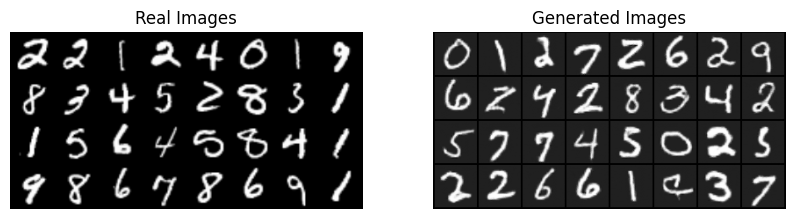

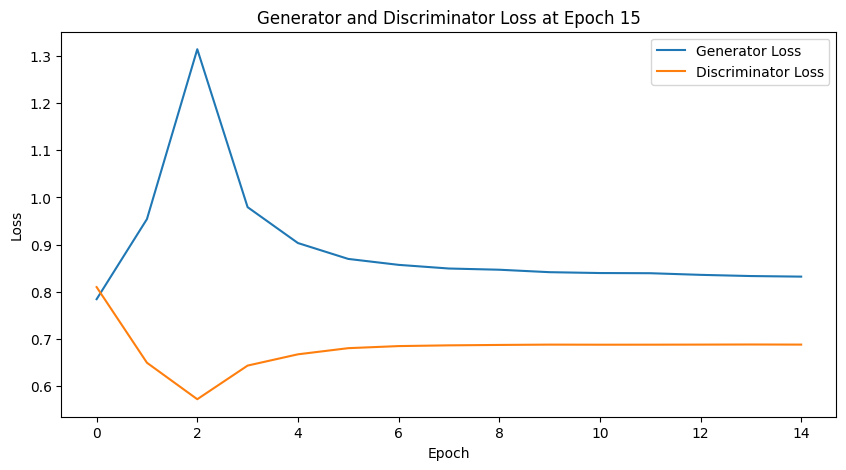

Epoch [16/30]: 100%|██████████| 938/938 [01:06<00:00, 14.14batch/s, Loss D=0.6910, Loss G=0.8560]


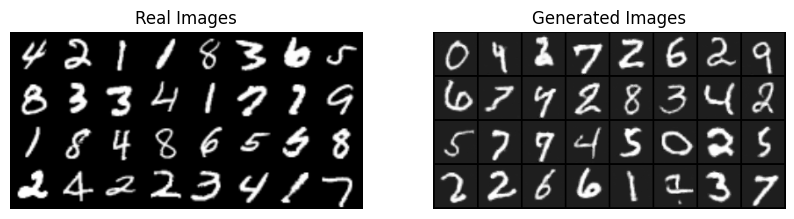

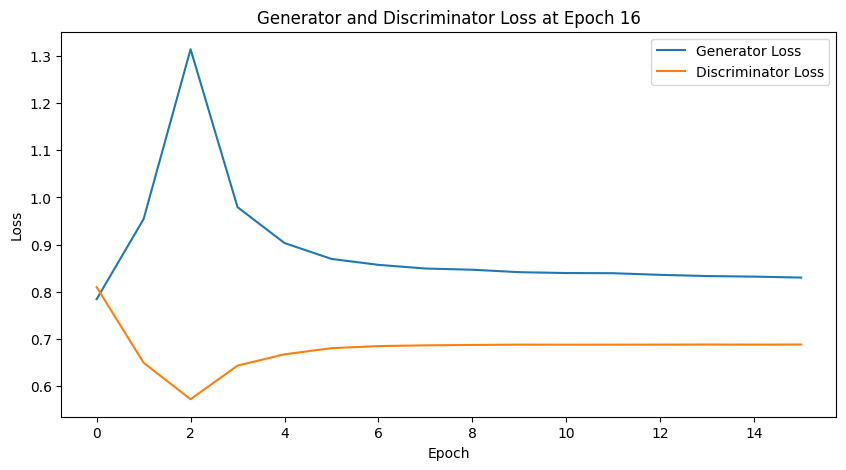

Epoch [17/30]: 100%|██████████| 938/938 [01:06<00:00, 14.18batch/s, Loss D=0.6944, Loss G=0.9054]


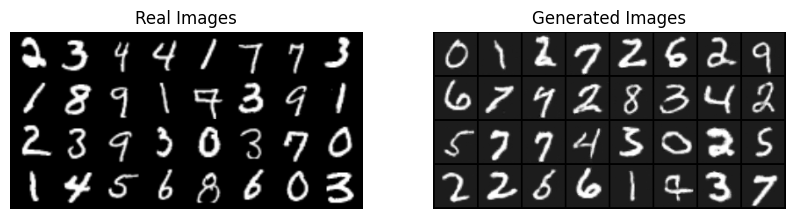

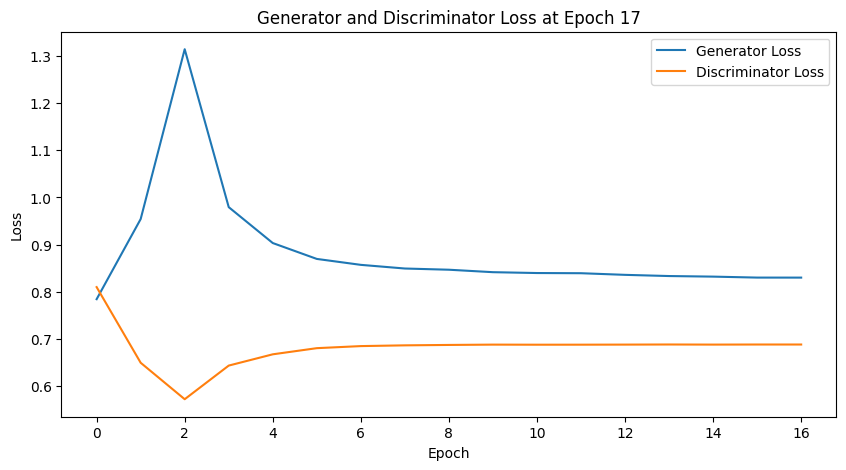

Epoch [18/30]: 100%|██████████| 938/938 [01:06<00:00, 14.18batch/s, Loss D=0.6852, Loss G=0.8337]


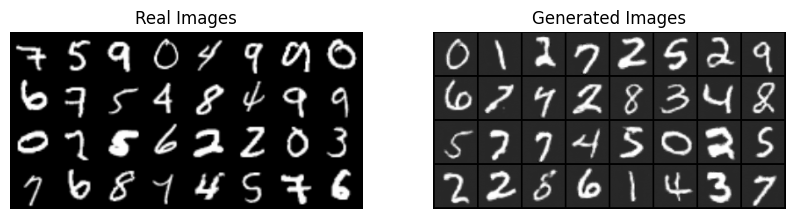

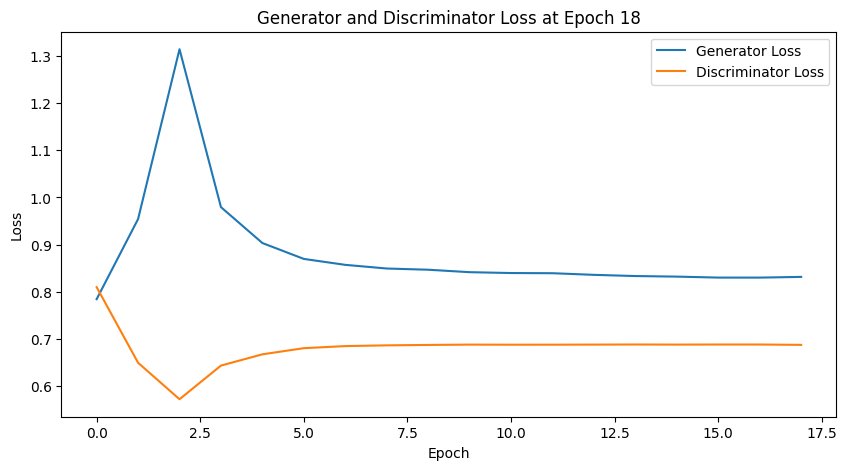

Epoch [19/30]: 100%|██████████| 938/938 [01:06<00:00, 14.15batch/s, Loss D=0.6738, Loss G=0.8547]


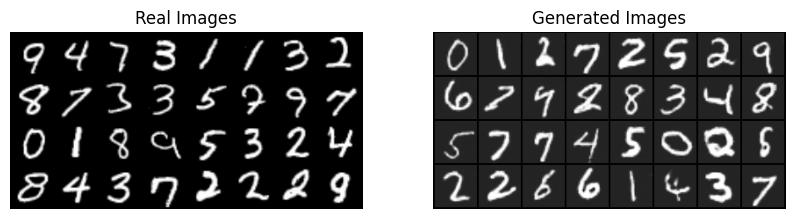

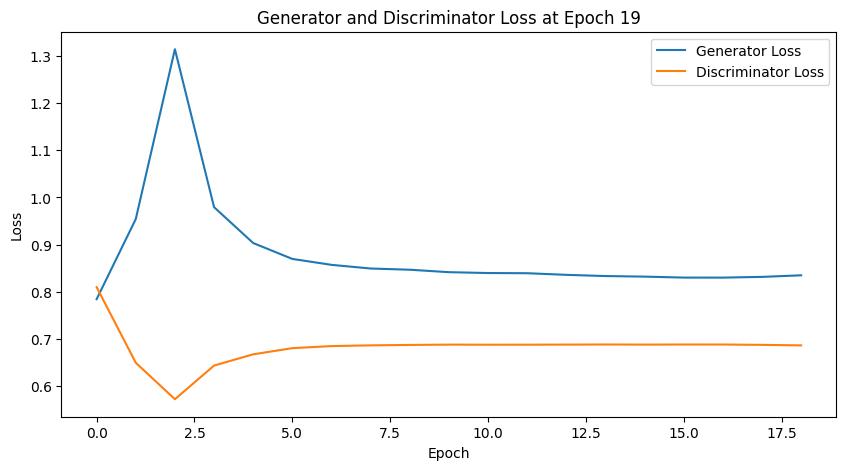

Epoch [20/30]: 100%|██████████| 938/938 [01:05<00:00, 14.22batch/s, Loss D=0.6801, Loss G=0.7763]


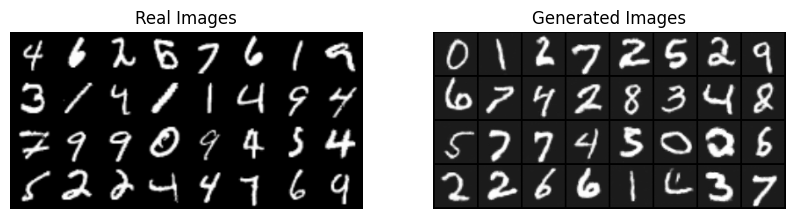

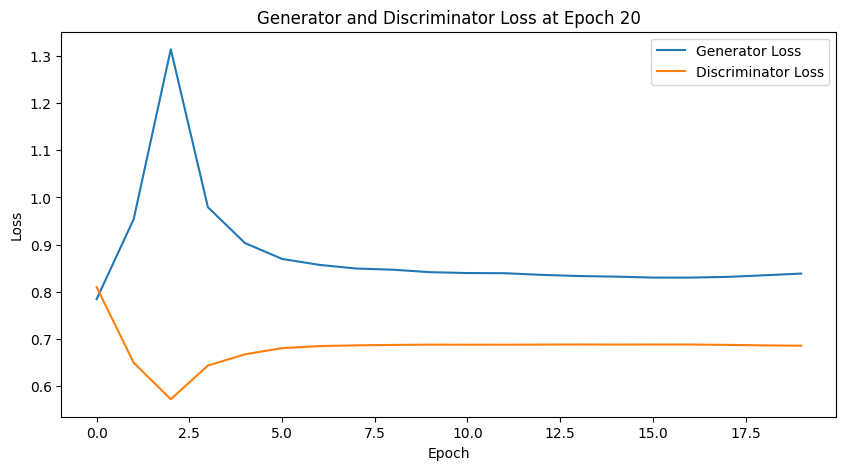

Epoch [21/30]: 100%|██████████| 938/938 [01:06<00:00, 14.16batch/s, Loss D=0.7093, Loss G=0.7479]


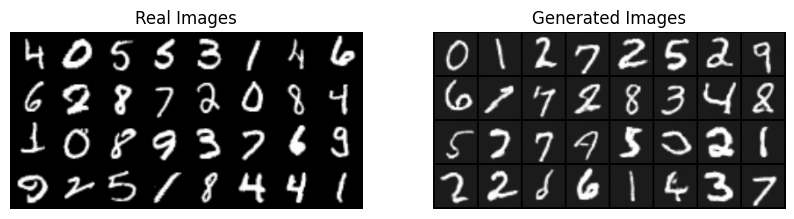

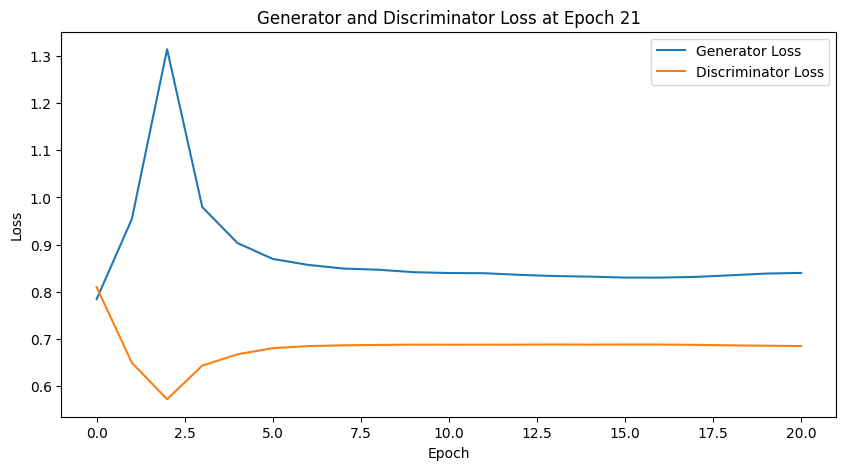

Epoch [22/30]: 100%|██████████| 938/938 [01:05<00:00, 14.24batch/s, Loss D=0.6841, Loss G=0.7621]


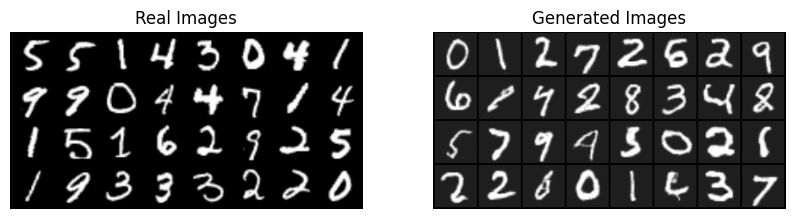

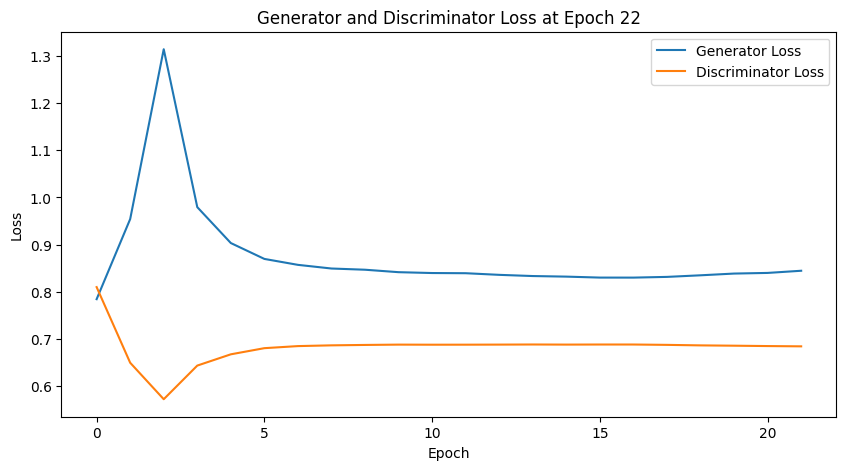

Epoch [23/30]:  16%|█▌        | 148/938 [00:10<00:56, 13.97batch/s, Loss D=0.6816, Loss G=0.8597]

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = generator(z_dim=100, channels_img=1, features_g=64).to(device)
disc = discriminator(channels_img=1, features_d=16).to(device)

gen.apply(weights_init)
disc.apply(weights_init)
#Loss function
criterion = nn.BCELoss().to(device)

# Optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0004, betas=(0.4, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.4, 0.999))

epochs = 30

# Fixed noise vector for visualization
fixed_noise = torch.randn(32, 100, 1, 1, device=device)

G_losses = []
D_losses = []
plot_interval = 100
real_label_smooth = 0.9

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
line1, = ax.plot([], [], label='Discriminator Loss', color='blue')
line2, = ax.plot([], [], label='Generator Loss', color='orange')
ax.legend()

# Start timer
start_time = time.time()

def show_images(real_batch, fake_batch):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(vutils.make_grid(real_batch[:32], padding=2, normalize=True).permute(1, 2, 0))

    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(vutils.make_grid(fake_batch[:32], padding=2, normalize=True).permute(1, 2, 0))

    plt.show()

# Training loop
for epoch in range(epochs):
    epoch_G_loss = []
    epoch_D_loss = []

    with tqdm(total=len(train_dataloader), desc=f"Epoch [{epoch+1}/{epochs}]", unit="batch") as pbar:
        for batch_idx, (real, _) in enumerate(train_dataloader):
            real = real.to(device)
            batch_size = real.size(0)


            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake = gen(noise)

            # Real and fake labels with label smoothing for real images
            real_labels = torch.full((batch_size,), real_label_smooth, device=device)
            fake_labels = torch.full((batch_size,), 0.0, device=device)

            # Forward pass for real images
            disc_real = disc(real).view(-1)
            loss_disc_real = criterion(disc_real, real_labels)

            # Forward pass for fake images
            disc_fake = disc(fake.detach()).view(-1)
            loss_disc_fake = criterion(disc_fake, fake_labels)

            # Total discriminator loss
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

            # Backprop and optimize
            opt_disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            ### Train Generator ###
            output = disc(fake).view(-1)
            loss_gen = criterion(output, torch.ones_like(output))

            # Backprop and optimize for the generator
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            # Store the losses for the current epoch
            epoch_G_loss.append(loss_gen.item())
            epoch_D_loss.append(loss_disc.item())

            # Update tqdm progress bar
            pbar.set_postfix({
                'Loss D': f'{loss_disc:.4f}',
                'Loss G': f'{loss_gen:.4f}'
            })
            pbar.update(1)

    # Display real images and generated images
    with torch.no_grad():
        fake_images = gen(fixed_noise).detach().cpu()
        real_batch = real.detach().cpu()
    show_images(real_batch, fake_images)

    G_losses.append(sum(epoch_G_loss) / len(epoch_G_loss))
    D_losses.append(sum(epoch_D_loss) / len(epoch_D_loss))

    # Plot the losses at the end of each epoch
    plt.figure(figsize=(10, 5))
    plt.title(f"Generator and Discriminator Loss at Epoch {epoch+1}")
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f} seconds.")

# Keep the final plot open
plt.ioff()
plt.show()
